In [197]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

In [198]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")
#df.describe(include="all").T
df.head(10)

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000,30,Full-time employee,Unlimited contract,English,51-100,Product
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,80000.0,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product
2,24/11/2020 11:14:21,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",120000.0,120000,30,Self-employed (freelancer),Temporary contract,English,101-1000,Product
3,24/11/2020 11:15:24,28.0,Male,Berlin,Frontend Developer,4,1,Junior,Javascript,NaN,54000.0,NaN,24,Full-time employee,Unlimited contract,English,51-100,Startup
4,24/11/2020 11:15:46,37.0,Male,Berlin,Backend Developer,17,6,Senior,C# .NET,".NET, SQL, AWS, Docker",62000.0,NaN,29,Full-time employee,Unlimited contract,English,101-1000,Product
5,24/11/2020 11:15:53,32.0,Male,Berlin,DevOps,5,1,Senior,"AWS, GCP, Python,K8s","Python, AWS, Google Cloud, Kubernetes, Docker",76000.0,5000,30,Full-time employee,Unlimited contract,English,11-50,Startup
6,24/11/2020 11:16:35,37.0,Male,Berlin,Frontend Developer,6,0.4,Middle,Javascript,NaN,57000.0,NaN,24,Full-time employee,Unlimited contract,English,11-50,Product
7,24/11/2020 11:16:44,24.0,Male,Berlin,Frontend Developer,5,1,Senior,Typescript,Javascript / Typescript,65000.0,NaN,27,Full-time employee,Unlimited contract,English,1000+,Product
8,24/11/2020 11:17:24,29.0,Male,Berlin,Backend Developer,8,2,Senior,PHP,"SQL, AWS, Docker",56000.0,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product
9,24/11/2020 11:17:50,35.0,Male,Berlin,Software Engineer,15,3,Lead,Java,NaN,95000.0,NaN,30,Full-time employee,Unlimited contract,English,101-1000,Product


In [199]:

df["Other technologies/programming languages you use often"].value_counts()

Javascript / Typescript                                                                   44
Python                                                                                    37
SQL                                                                                       31
AWS, Docker                                                                               16
Kotlin                                                                                    15
                                                                                          ..
Python, Ruby, Java / Scala, Go, Rust, AWS, Kubernetes, Docker, Terraform, helm, packer     1
Kotlin, SQL, AWS, Kubernetes, Docker                                                       1
Python, R, Go                                                                              1
C/C++, PHP, SQL                                                                            1
Python, AWS, Kubernetes, Docker, terraform, ansible                   

### Exploratory Data Analysis (EDA) 
EDA is going to help us inanalyzing and summarizing our data set's main characteristics. Also, to identify underlying structure of our data, to spot anomalies and outliers, to test underlying assumptions, and to form hypotheses that can be further tested.

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 18 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Timestamp                                               1253 non-null   object 
 1   Age                                                     1226 non-null   float64
 2   Gender                                                  1243 non-null   object 
 3   City                                                    1253 non-null   object 
 4   Position                                                1247 non-null   object 
 5   Total years of experience                               1237 non-null   object 
 6   Years of experience in Germany                          1221 non-null   object 
 7   Seniority level                                         1241 non-null   object 
 8   Your main technology / programming lan

In [201]:
#df['Yearly brutto salary (without bonus and stocks) in EUR'].astype(int)

In [202]:
df.describe()

,Age,Yearly brutto salary (without bonus and stocks) in EUR
count,1226.000000,1.253000e+03
mean,32.509788,8.027904e+07
std,5.663804,2.825061e+09
min,20.000000,1.000100e+04
25%,29.000000,5.880000e+04
50%,32.000000,7.000000e+04
75%,35.000000,8.000000e+04
max,69.000000,1.000000e+11


In [203]:
df['Yearly brutto salary (without bonus and stocks) in EUR']

0        80000.0
1        80000.0
2       120000.0
3        54000.0
4        62000.0
          ...   
1248     70000.0
1249     60000.0
1250    110000.0
1251     38350.0
1252     65000.0
Name: Yearly brutto salary (without bonus and stocks) in EUR, Length: 1253, dtype: float64

### Identifying numerical and categorical variables 
It is an important step in the data preprocessing and analysis phase because:
<br>
<br>Data Preparation: Numerical variables may require scaling, while categorical variables need to be one-hot encoded before they can be used as inputs to the model.

<br>Exploratory Data Analysis: Identifying numerical and categorical variables can help in understanding the structure and distribution of the data, and identify any potential outliers or anomalies.

<br>Feature Selection: Numerical and categorical variables may have different feature importances in or model, and this information can be used to select relevant features.

<br >Model Selection: For correct model selection.For example, decision trees and random forests are commonly used for categorical data, while linear regression is used for numerical data.

In [204]:
def find_categorical_numerical(df):
    categorical = []
    numerical = []
    for col in df.columns:
        if df[col].dtype == 'object':
            categorical.append(col)
        else:
            numerical.append(col)
    return categorical, numerical

In [205]:
categorical, numerical = find_categorical_numerical(df)

In [206]:
# Categorical data is 


print("categorical Data:")
categorical

categorical Data:


['Timestamp',
 'Gender',
 'City',
 'Position ',
 'Total years of experience',
 'Years of experience in Germany',
 'Seniority level',
 'Your main technology / programming language',
 'Other technologies/programming languages you use often',
 'Yearly bonus + stocks in EUR',
 'Number of vacation days',
 'Employment status',
 'Сontract duration',
 'Main language at work',
 'Company size',
 'Company type']

In [207]:
# Numerical data is :


print("Numerical data:")
numerical

Numerical data:


['Age', 'Yearly brutto salary (without bonus and stocks) in EUR']

In [208]:
#Defining outliers
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in numerical:
    print(col, check_outlier(df, col))
#person_age, person_income and person_emp_lenght have some outlier observations

Age False
Yearly brutto salary (without bonus and stocks) in EUR True


In [209]:
outlier_thresholds(df, numerical)

(Age                                                          -16.0
 Yearly brutto salary (without bonus and stocks) in EUR   -200200.0
 dtype: float64,
 Age                                                           88.0
 Yearly brutto salary (without bonus and stocks) in EUR    385336.0
 dtype: float64)

### Finding nan's in our dataset:
The presence of NaN values can impact the accuracy and reliability of the results of any analysis or modeling performed on the dataset. It is therefore important to handle missing values appropriately, either by imputing the missing values or removing the observations with missing values.

In [210]:
df.isna().sum()
#Replacing Outliers

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > (up_limit-150000)), variable] = up_limit

for col in numerical:
    replace_with_thresholds(df, col)

#Check
for col in numerical:
    print(col, check_outlier(df, col))

Age False
Yearly brutto salary (without bonus and stocks) in EUR False


In [211]:
df.describe()

,Age,Yearly brutto salary (without bonus and stocks) in EUR
count,1226.0,1253.00000
mean,88.0,72076.90992
std,0.0,31194.80354
min,88.0,10001.00000
25%,88.0,58800.00000
50%,88.0,70000.00000
75%,88.0,80000.00000
max,88.0,385336.00000


### Imputation
Imputing  is the process of replacing missing (categorical and numerical) or invalid values in a dataset with estimated values.

In [212]:
#Imputing for categorical variables, filling the missing values with the mode of the data.
df['Gender']=df['Gender'].fillna(df['Gender'].mode()[0])
df['Position ']=df['Position '].fillna(df['Position '].mode()[0])
df['Total years of experience']=df['Total years of experience'].fillna(df['Total years of experience'].mode()[0])
df['Seniority level']=df['Seniority level'].fillna(df['Seniority level'].mode()[0])
df['Your main technology / programming language']=df['Your main technology / programming language'].fillna(df['Your main technology / programming language'].mode()[0])
df['Other technologies/programming languages you use often']=df['Other technologies/programming languages you use often'].fillna(df['Other technologies/programming languages you use often'].mode()[0])
df['Yearly bonus + stocks in EUR']=df['Yearly bonus + stocks in EUR'].fillna(df['Yearly bonus + stocks in EUR'].mode()[0])
df['Number of vacation days']=df['Number of vacation days'].fillna(df['Number of vacation days'].mode()[0])
df['Employment status']=df['Employment status'].fillna(df['Employment status'].mode()[0])
df['Сontract duration']=df['Сontract duration'].fillna(df['Сontract duration'].mode()[0])
df['Main language at work']=df['Main language at work'].fillna(df['Main language at work'].mode()[0])
df['Company size']=df['Company size'].fillna(df['Company size'].mode()[0])
df['Company type']=df['Company type'].fillna(df['Company type'].mode()[0])

In [213]:
#Imputing numerical variables, filling the missing values with Mean of the data.
df['Age']=df['Age'].fillna(df['Age'].mean())


In [214]:
# Drop the timestamp as it is irrelevant 
df=df.drop(['Timestamp'],axis=1)

In [215]:
# Drop the 'Years of experience in Germany' as it is irrelevant 
df=df.drop(['Years of experience in Germany'],axis=1)

In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 16 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Age                                                     1253 non-null   float64
 1   Gender                                                  1253 non-null   object 
 2   City                                                    1253 non-null   object 
 3   Position                                                1253 non-null   object 
 4   Total years of experience                               1253 non-null   object 
 5   Seniority level                                         1253 non-null   object 
 6   Your main technology / programming language             1253 non-null   object 
 7   Other technologies/programming languages you use often  1253 non-null   object 
 8   Yearly brutto salary (without bonus an

In [217]:
df.sample(5)

,Age,Gender,City,Position,Total years of experience,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
520,88.0,Male,Berlin,Software Engineer,4,Middle,C#,"Javascript / Typescript, .NET, Azure, Docker",65000.0,0,30,Full-time employee,Unlimited contract,English,101-1000,Product
479,88.0,Male,Berlin,Frontend Developer,6,Senior,JavaScript,"Javascript / Typescript, Docker",66000.0,0,24,Full-time employee,Unlimited contract,English,1000+,Product
481,88.0,Male,Munich,Software Engineer,10,Senior,.NET,"Python, Javascript / Typescript, Azure",75000.0,5000,30,Full-time employee,Unlimited contract,English,1000+,Product
624,88.0,Male,Berlin,Software Engineer,10,Lead,C/C++,C/C++,95000.0,15000,30,Full-time employee,Unlimited contract,English,1000+,Product
1086,88.0,Male,Munich,Software Engineer,14,Senior,C++,"Python, C/C++",98000.0,28000,30,Full-time employee,Unlimited contract,English,1000+,Product


In [218]:
df['Seniority level']=df['Seniority level'].astype('category')
df['Position ']=df['Position '].astype('category')
df['Total years of experience']=df['Total years of experience'].astype('category')
df['Gender']=df['Gender'].astype('category')
df['Yearly brutto salary (without bonus and stocks) in EUR']=df['Yearly brutto salary (without bonus and stocks) in EUR'].astype(int)

<AxesSubplot:xlabel='Total years of experience', ylabel='count'>

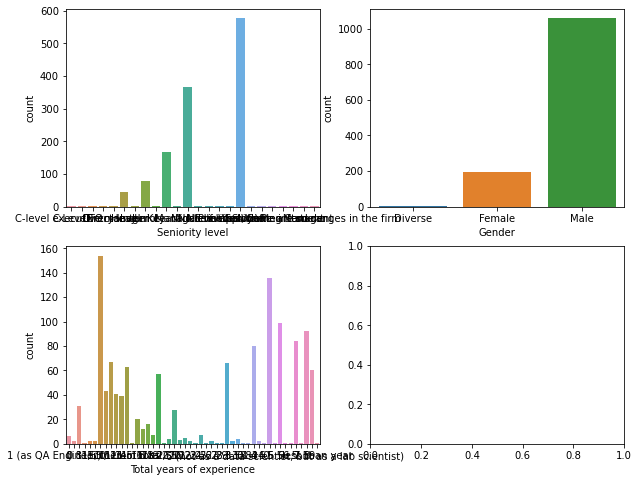

In [219]:
#Countplots for categorical variable
fig, ax=plt.subplots(nrows=2,ncols=2,figsize=(10,8))
sns.countplot(x='Seniority level', data=df,ax=ax[0,0])
sns.countplot(x='Gender',data=df,ax=ax[0,1])
sns.countplot(x='Total years of experience',data=df,ax=ax[1,0])

<AxesSubplot:xlabel='Gender', ylabel='Yearly brutto salary (without bonus and stocks) in EUR'>

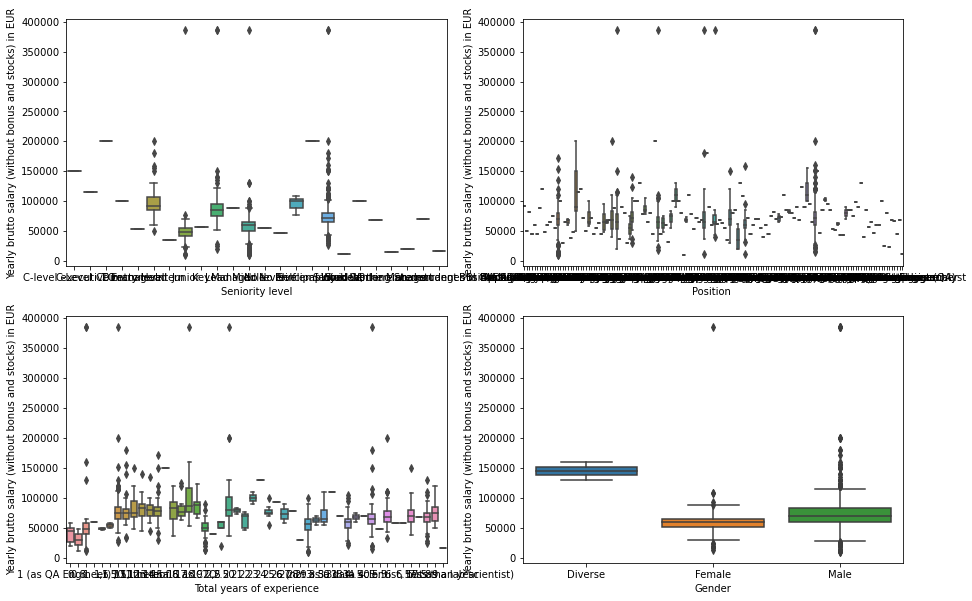

In [220]:
import seaborn as sns
import matplotlib.pyplot as plt


#Categorical Plotting
fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(15,10))
sns.boxplot(x='Seniority level',y='Yearly brutto salary (without bonus and stocks) in EUR',data=df,ax=ax[0,0])
sns.boxplot(x='Position ',y='Yearly brutto salary (without bonus and stocks) in EUR',data=df ,ax=ax[0,1])
sns.boxplot(x='Total years of experience',y='Yearly brutto salary (without bonus and stocks) in EUR',data=df ,ax=ax[1,0])
sns.boxplot(x='Gender',y='Yearly brutto salary (without bonus and stocks) in EUR',data=df ,ax=ax[1,1])

<AxesSubplot:xlabel='Yearly brutto salary (without bonus and stocks) in EUR', ylabel='Density'>

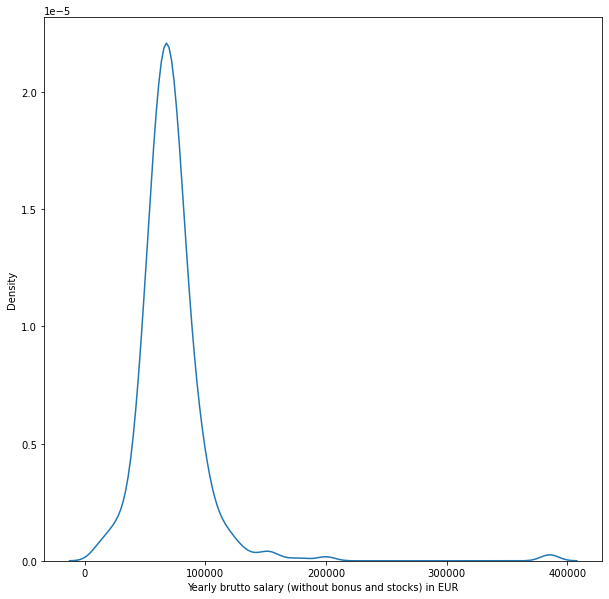

In [221]:
sns.kdeplot(data=df, x="Yearly brutto salary (without bonus and stocks) in EUR")

In [223]:
df.head(2)

,Age,Gender,City,Position,Total years of experience,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
0,88.0,Male,Munich,Software Engineer,5,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000,5000,30,Full-time employee,Unlimited contract,English,51-100,Product
1,88.0,Male,Berlin,Backend Developer,7,Senior,Ruby,Javascript / Typescript,80000,0,28,Full-time employee,Unlimited contract,English,101-1000,Product


In [224]:
y = df["Yearly brutto salary (without bonus and stocks) in EUR"]
X = df.drop(columns={"Yearly brutto salary (without bonus and stocks) in EUR"})

In [225]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.ensemble import RandomForestClassifier 

In [226]:
#Tree Based
tree_sel = RandomForestClassifier().fit(X, y)
sfm_class = SelectFromModel(tree_sel, prefit=True)
x_new = sfm_class.transform(X)
print(x_new.shape)

mask = sfm_class.get_support()
new_features = X.columns[mask]
print(new_features)

ValueError: could not convert string to float: 'Male'

In [ ]:
post_mut_inf = SelectPercentile(score_func=mutual_info_classif, percentile=50).fit_transform(X,y.ravel())
print("Mutual Info:", post_mut_inf.shape)

ValueError: could not convert string to float: 'Male'

# Answers and Explainations
(Expand/modify as needed)

### Results

### Feature Selection Activities

### Hyperparameter Changes